PROBLEM 7: DBSCAN on real data

Run the DBSCAN algorithm on:

1. 20NG

2. FASHION 

3. HouseHold (see papers), and evaluate results.

You need to implement both phases:
1) Neighborhoods creation

2) DBSCAN

Explain why/when it works, and speculate why/when not. You need to trial and error for parameters epsilon and MinPts

In [3]:
import sklearn
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

### FASHION DATASET:

In [4]:
data_fashion = torchvision.datasets.FashionMNIST(root='./fashion', download=True, transform=transforms.ToTensor())
print(data_fashion[0][0])

100%|██████████| 26.4M/26.4M [00:43<00:00, 611kB/s]


Extracting ./fashion\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./fashion\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 305kB/s]


Extracting ./fashion\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./fashion\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:06<00:00, 652kB/s]


Extracting ./fashion\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./fashion\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.15MB/s]

Extracting ./fashion\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./fashion\FashionMNIST\raw

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.

In [5]:
data_fashion_numpy = data_fashion.data.numpy()
print(data_fashion_numpy[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 23

In [6]:
# labels?
print(data_fashion.targets)
data_fashion_labels = data_fashion.targets.numpy()
print(data_fashion_labels)

tensor([9, 0, 0,  ..., 3, 0, 5])
[9 0 0 ... 3 0 5]


In [7]:
# test euclidean distances between the two types (tensors and numpy arrays)

print("Between tensors: ", torch.dist(data_fashion[0][0], data_fashion[1][0]), "using norm: ", torch.norm(data_fashion[0][0] - data_fashion[1][0]), "using numpy: ", np.linalg.norm(data_fashion[0][0].numpy() - data_fashion[1][0].numpy()))
print("Between numpy arrays: ", np.linalg.norm(data_fashion_numpy[0] - data_fashion_numpy[1]))

Between tensors:  tensor(14.6757) using norm:  tensor(14.6757) using numpy:  14.675714
Between numpy arrays:  3648.6486539539537


In [10]:
# truncate to 1000 samples
data_fashion_numpy = data_fashion_numpy[:1000]
data_fashion_labels = data_fashion_labels[:1000]

In [11]:
# 1. Compute distances, get neighbors:

def euclidean_distance(x, y):
    return np.linalg.norm(x - y)

def get_neighbors(df, point, epsilon):
    neighbors = []
    for i in range(len(df)):
        if euclidean_distance(df.iloc[i], point) < epsilon:
            neighbors.append(i)
    return neighbors

# 2. DBSCAN algorithm:
def dbscan(df, epsilon, min_points):
    labels = [0] * len(df)
    c = 0
    for i in tqdm(range(len(df))):
        if labels[i] != 0:
            continue
        neighbors = get_neighbors(df, df.iloc[i], epsilon)
        if len(neighbors) < min_points:
            labels[i] = -1
            continue
        c += 1
        labels[i] = c
        for j in neighbors:
            if labels[j] == -1:
                labels[j] = c
            if labels[j] != 0:
                continue
            labels[j] = c
            new_neighbors = get_neighbors(df, df.iloc[j], epsilon)
            if len(new_neighbors) >= min_points:
                neighbors.extend(new_neighbors)
    return labels


100%|██████████| 1000/1000 [04:24<00:00,  3.78it/s]


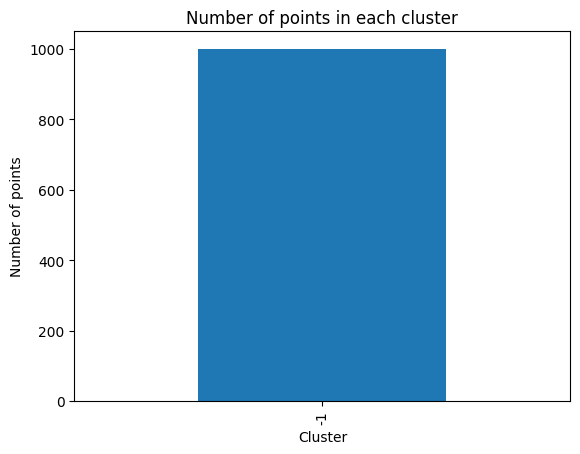

In [12]:
# 3. Run DBSCAN on FashionMNIST data:
fashion_df = pd.DataFrame(data_fashion_numpy.reshape(len(data_fashion_numpy), -1))
fashion_df['label'] = data_fashion_labels
epsilon = 100
min_points = 10
labels = dbscan(fashion_df, epsilon, min_points)
fashion_df['cluster'] = labels
fashion_df['cluster'].value_counts()
fashion_df['cluster'].value_counts().plot(kind='bar')
plt.title('Number of points in each cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of points')
plt.show()
